# Localization & Classification

## 1. Description of the contents of the dataset

### For this localization task, inorder to increase accuarcy, we decided to train 10 different models, each for one class of objects. For each every class, we use 500 positive images and 1800 negative images with 12 stages. For each sample, we downscale the bounding box size to 20X20 to improve the training speed. 

In [85]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from scipy.misc import imread
import csv
import sys
from os import listdir
from os.path import join, splitext, basename
from sklearn.neighbors import DistanceMetric
import pandas as pd
import seaborn as sns
from scipy import stats

In [86]:
# load all the then classifier
bic_cascade = cv2.CascadeClassifier('bicycle.xml')
bus_cascade = cv2.CascadeClassifier('bus.xml')
car_cascade = cv2.CascadeClassifier('car.xml')
motor_cascade = cv2.CascadeClassifier('motor.xml')
non_motor_cascade = cv2.CascadeClassifier('non_motor.xml')
pedastrian_cascade = cv2.CascadeClassifier('pedastrain.xml')
pickup_truck_cascade = cv2.CascadeClassifier('pickup_truck.xml')
singleunit_truck_cascade = cv2.CascadeClassifier('singleunit_truck.xml')
truck_cascade = cv2.CascadeClassifier('truck.xml')
work_van = cv2.CascadeClassifier('work_van.xml')


obj_cascade = []


if not os.path.exists('xml'):
        os.makedirs('xml')


#where the .xml file is located
path_classifier = "xml"


for filePath in sorted(os.listdir(path_classifier)):
    fileExt = os.path.splitext(filePath)[1]
    if fileExt in [".xml"]:
        imagePath = os.path.join(path_classifier, filePath)
        img_gray = cv2.CascadeClassifier(imagePath)
        obj_cascade.append(img_gray)
        
        

        
        
#print(obj_cascade)


    

[<CascadeClassifier 0x1a294993d0>, <CascadeClassifier 0x1a29499370>, <CascadeClassifier 0x1a294995d0>, <CascadeClassifier 0x1a29499130>, <CascadeClassifier 0x1a29499230>, <CascadeClassifier 0x1a29499610>, <CascadeClassifier 0x1a29499330>, <CascadeClassifier 0x1a29499390>, <CascadeClassifier 0x1a29499350>, <CascadeClassifier 0x1a294993f0>]


Reading images from image_folder...

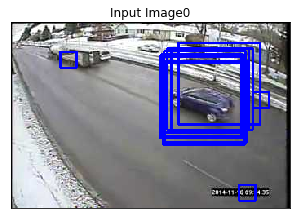

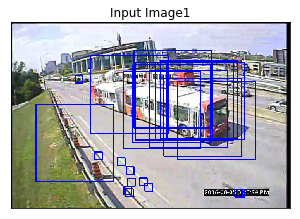

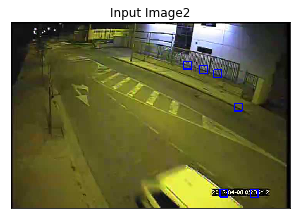

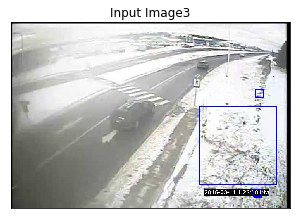

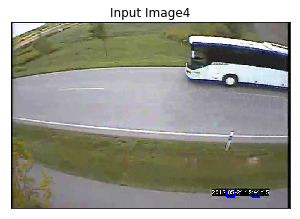

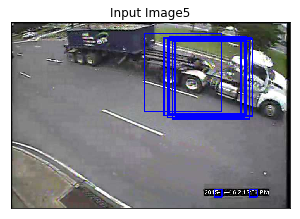

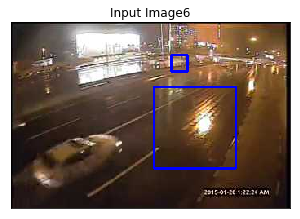

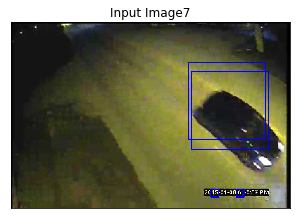

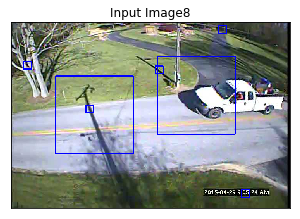

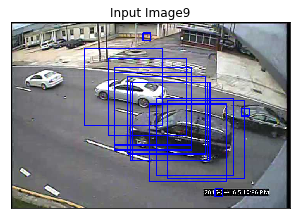

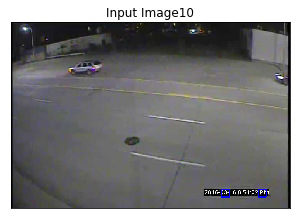

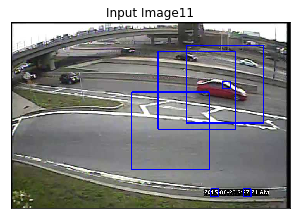

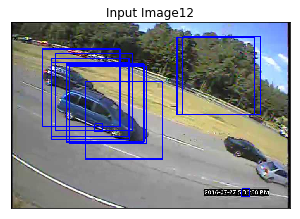

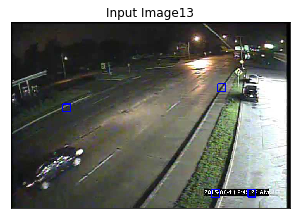

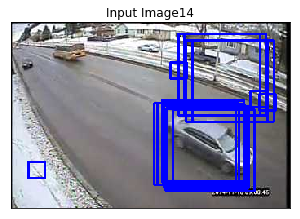

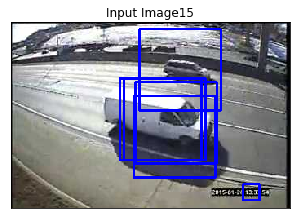

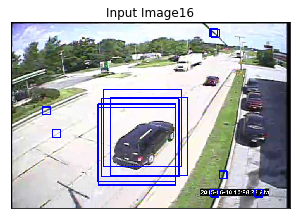

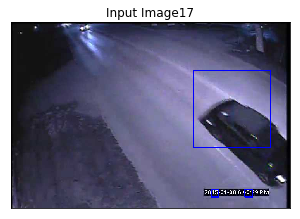

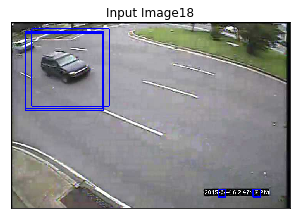

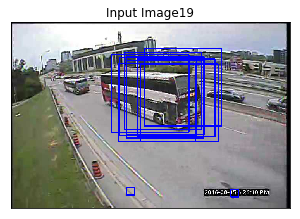

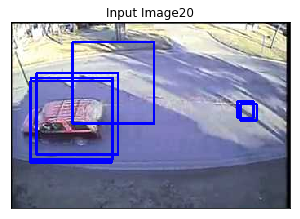

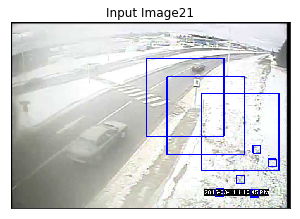

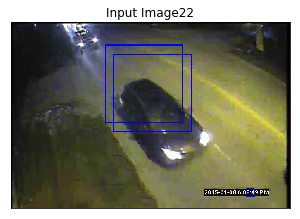

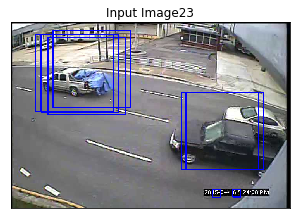

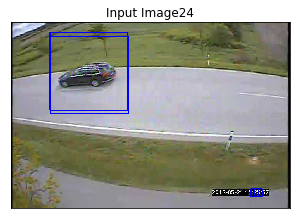

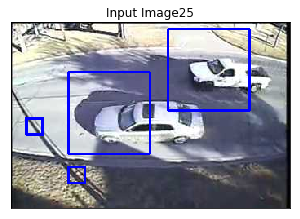

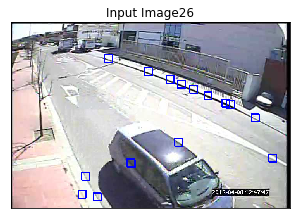

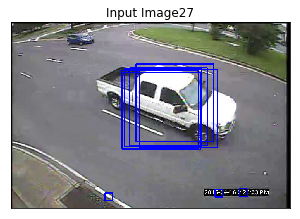

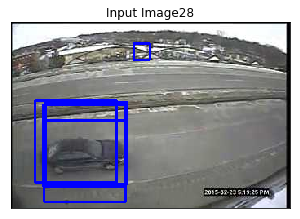

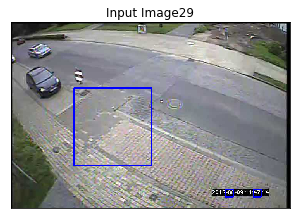

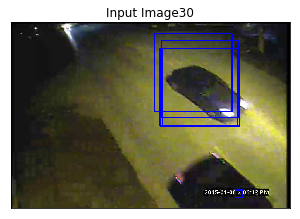

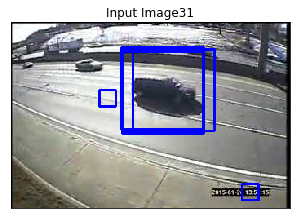

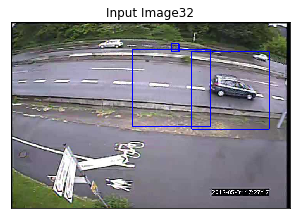

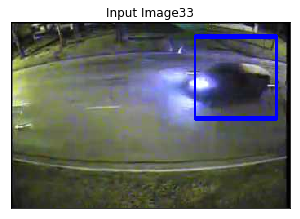

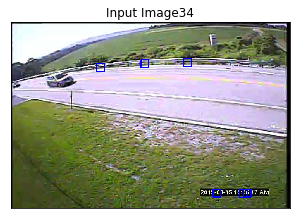

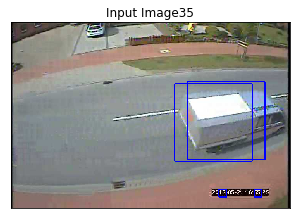

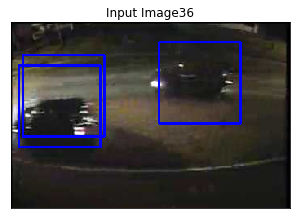

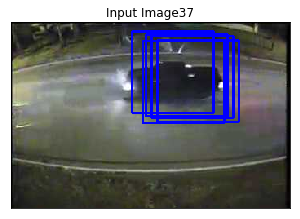

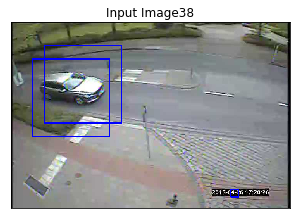

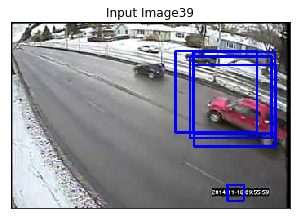

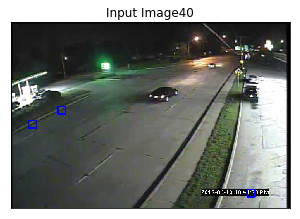

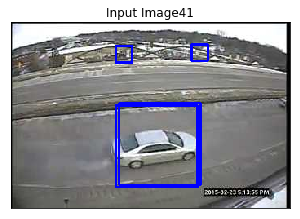

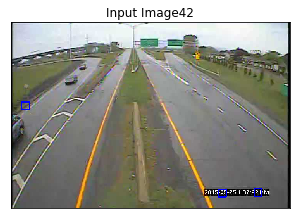

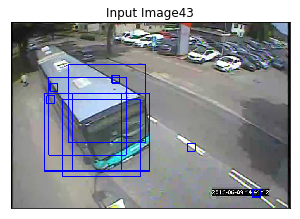

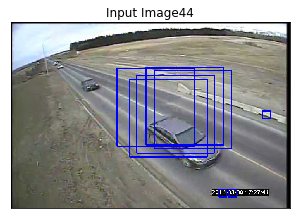

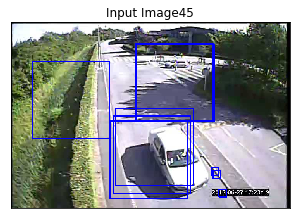

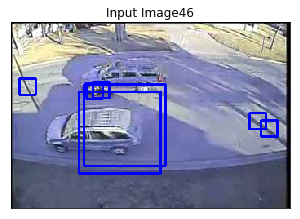

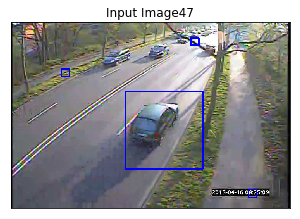

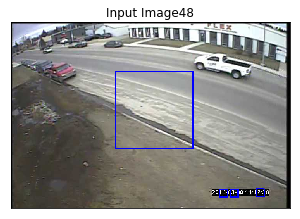

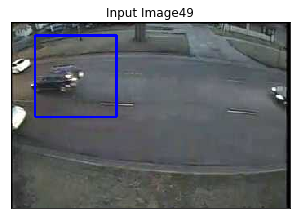

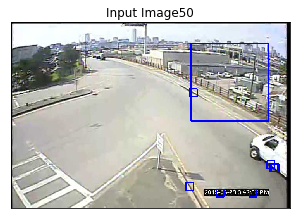

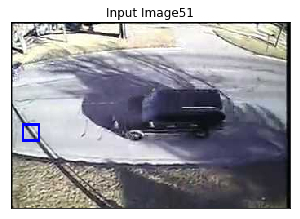

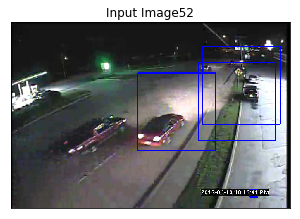

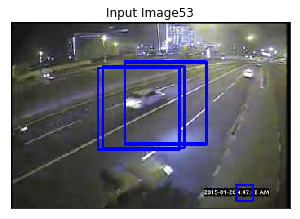

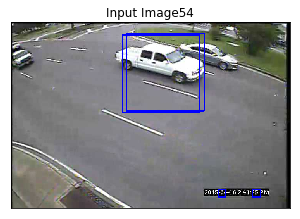

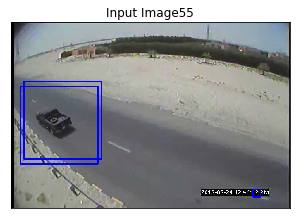

In [87]:
img_list = [] # a list to store all the img read from folder

#img_copy = []

objloc = [] # a list to store all the location of the objects we detected

# load all the images in greyscale and store them into an array
path = "image_folder"

print("Reading images from " + path, end="...")

i = 0 # counter to loop the img_list

for filePath in sorted(os.listdir(path)):
    fileExt = os.path.splitext(filePath)[1]
    if fileExt in [".png", ".jpeg",".jpg"]:
        imagePath = os.path.join(path, filePath)
        img_gray = cv2.imread(imagePath,cv2.COLOR_BGR2GRAY)
        im = cv2.resize(img_gray, None, fx=1, fy=1)
        if im is None :
                print("image:{} not read properly".format(imagePath))
        else :
            img_list.append(im)
            #img_copy.append(im)
            # get the size of the image, so that we can set the parameters accordingly
            _, size, _ = img_list[i].shape

    
    for j in range(len(obj_cascade)):
        # for big picture, we use one reduction scale and neighbours
        if(size > 500):
            obj = obj_cascade[j].detectMultiScale(img_gray, 10,25)
        # for smaller picture, we use another reduction scale and neighbours
        if(size < 500):
            obj = obj_cascade[j].detectMultiScale(img_gray, 5,20)
        
        # get the x,y,w,h in the obj and store the (x1,y1) (x2,y2) to the objloc list
        # the objloc list has this format:
        # objloc[0] = current picture number
        # objloc[1,2] = x1, y1
        # objloc[3,4] = x2, y2
        for (x,y,w,h) in obj:
            cv2.rectangle(img_list[i], (x,y), (x+w, y+h), (255,0,0), 2)
            x2 = x + w - 1
            y2 = y + h - 1
            objloc.append([i, x, y, x2, y2])
    
    # display images
    plt.figure(figsize=(5,5))
    plt.imshow(cv2.cvtColor(img_list[i], cv2.COLOR_BGR2RGB))
    plt.title("Input Image" + str(i)), plt.xticks([]), plt.yticks([])
    plt.show()
    i=i+1

In [88]:
ground_truth_label = [] # a list to store the ground truth from the CSV, this list include labels

# codes for reading from csv
with open('gt_test.csv', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        ground_truth_label.append(row)

In [89]:
ground_truth = [] # a list to store the ground truth without labels, all the locations are in int

# use loop to extract the only features we need and store them into ground_truth list
for i in range(len(ground_truth_label)):
    
    temp = [int(ground_truth_label[i][0]), int(ground_truth_label[i][2]), int(ground_truth_label[i][3]), 
            int(ground_truth_label[i][4]), int(ground_truth_label[i][5])]
    
    # use x1, y1 and w, h to calculate x2, y2 and store them into the ground_truth list
    temp[3] = temp[1]+temp[3]
    temp[4] = temp[2]+temp[4]
    
    # the ground_truth list has this format:
    # ground_truth[0] = current picture number
    # ground_truth[1,2] = x1, y1
    # ground_truth[3,4] = x2, y2
    ground_truth.append(temp) 
    

In [90]:
pic = 0 # a varaible use to determine which picture we are now comparing with
 
index = [] # store the index of objloc that has the best fit

DICE = [0] * len(ground_truth) # create an array with all zeros to store the maximum dice we get latter
index = [0] * len(ground_truth) # store the index of the maximum dice we find for later finding the corp of the largest dice

for i in range(len(ground_truth)):
    # check if the current list in the ground_truth we have contains the locations for picture number 'pic'
    if(ground_truth[i][0] == pic):
        # get the locations of the ground_truth at picture number 'pic'
        x1 = ground_truth[i][1]
        y1 = ground_truth[i][2]
        x2 = ground_truth[i][3]
        y2 = ground_truth[i][4]
        
        for j in range(len(objloc)): 
            # check if the current list in the objloc we have contains the locations for picture number 'pic'
            # we only calculate the dice if both of the objloc we find and the ground truth are for the same image
            if(objloc[j][0] == pic):
                # get the locations of the objloc at picture number 'pic'
                x3 = objloc[j][1]
                y3 = objloc[j][2]
                x4 = objloc[j][3]
                y4 = objloc[j][4]
                
                # from the dice equation, we know the denominator is just the sum of the ground_truth area and the obj area
                # we found. So we just calculate the total area of these two as the denominator
                totalarea = abs(x1-x2)*abs(y1-y2) + abs(x3-x4)*abs(y3-y4)

                # To calculate the intersect area, we need to find the minimum of x, y and maximum of x, y
                xmin = max(x1, x3)
                ymin = max(y1, y3)
                xmax = min(x2, x4)
                ymax = min(y2, y4)

                # find the width and height of the intersected area
                width = (xmax - xmin)
                height = (ymax - ymin)
                
                # calculate the intersected area
                cross_square = 2*width*height
                
                # we eleminate the case when these two boxes have no intersection
                if (width <= 0) or (height <= 0):
                    cross_square = 0
                
                # calculate the dice
                dice = cross_square/totalarea
            
                # store the dice to the DICE list only if the new one is bigger than the previous one we have
                if(dice > DICE[i]):
                    # update the dice for ground_truth[i] if the new one is bigger
                    # after the loop finish, this array should store the largest dice for each object detected in ground_truth
                    DICE[i] = dice
                    # store the index of the boxes that we find have the largest dice
                    index[i] = [pic,j]

    # if now the ground_truth is not belong to the pic number we have, we add the pic number
    if(ground_truth[i][0] != pic):
        pic = pic + 1

In [91]:
img_copy = []
for filePath in sorted(os.listdir(path)):
    fileExt = os.path.splitext(filePath)[1]
    if fileExt in [".png", ".jpeg",".jpg"]:
        imagePathC = os.path.join(path, filePath)
        img_grayC = cv2.imread(imagePathC,cv2.COLOR_BGR2GRAY)
        imC = cv2.resize(img_grayC, None, fx=1, fy=1)
        if im is None :
                print("image:{} not read properly".format(imagePath))
        else :
            #img_list.append(im)
            img_copy.append(imC)

In [92]:
csv = [] # a list to store the csv information. This list has the cropped picture number and the corresponding ground_truth label

# store the cropped images to the crop_image folder
if not os.path.exists('crop_image'):
        os.makedirs('crop_image')

name = 0 # a varaible for the name of the cropped image

# according to the index we have for the picture that have the largest dice, we crop the image
for i in range(len(index)):
    if(index[i] != 0): # elminate the case where we find nothing
        # get the corresponding img
        img = img_copy[index[i][0]]
        # get the corresponding position
        loc = objloc[index[i][1]]
        x1 = loc[1]
        y1 = loc[2]
        x2 = loc[3]
        y2 = loc[4]
        # do crop
        crop = img[y1:y2, x1:x2]
        # save the image
        cv2.imwrite("crop_image/"+str(name)+".jpg",crop)
        csv.append([name, ground_truth_label[i][1]])
        img_crop.append(crop)
        # increase the name
        name = name + 1
    

In [93]:
print(np.mean(DICE))

0.19610989325103148


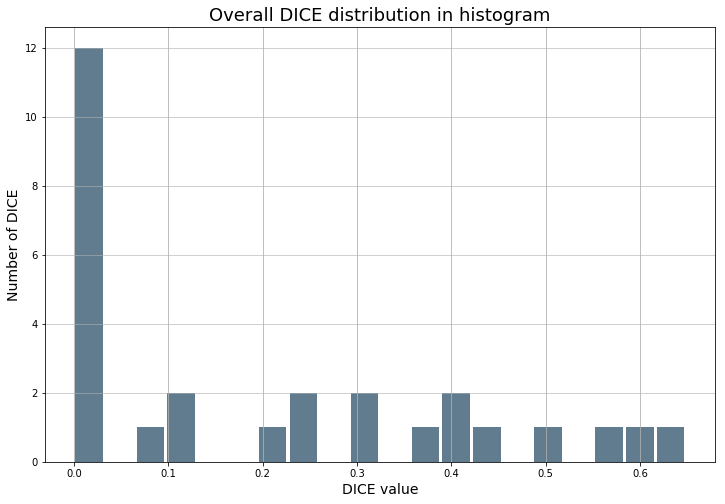

In [94]:
# reference https://realpython.com/python-histograms/
DICE_plot = pd.Series(DICE)

plt.figure(figsize=(12,8))
DICE_plot.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Overall DICE distribution in histogram', fontsize=18)
plt.xlabel('DICE value', fontsize=14)
plt.ylabel('Number of DICE', fontsize=14)
plt.grid(axis='y', alpha=0.75)

In [95]:
print(len(DICE))

28


In [96]:
print(DICE)

[0.4035297769500244, 0.29976569930637714, 0.42761940022213996, 0.11359345500314663, 0.23483518626877317, 0, 0.5584238790014783, 0.20462308264327397, 0.6482602873873333, 0.5102334701881243, 0, 0, 0, 0.3926504852331008, 0, 0, 0.3592758415778706, 0, 0, 0, 0, 0, 0.10213791272742123, 0.2385946414113837, 0.6147075943963677, 0.08135267248978284, 0.3014736262222834, 0]


In [97]:
print(len(img_crop))

16
